In [2]:
import numpy as np
import pandas as pd
import time                 ### to guage execution time of code
from scipy import optimize
from tqdm import tqdm       ### to show progress in loops

In [3]:
# comment out if using jupyter directly from system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# directory from your google drive to include data and other excel files.
import os
os.chdir('/content/drive/My Drive/AOP_Final_Project')

In [5]:
dataframe_fwd_3320_T_11 = pd.read_excel("fwd_3320_T_11.xlsx")

In [6]:
type(dataframe_fwd_3320_T_11.MarketVol)

pandas.core.series.Series

In [7]:
#Implementation of Hagan's formula eq2.17 for beta = 1
def SABR2Black76(F0, K, T, alpha, rho, nu):
  z = nu / alpha * np.log(F0 / K)
  xz = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
  if z==0:
    return alpha*(1+ (0.25*rho*alpha*nu + ((2-3*(rho**2))/24)*(nu**2))*T)
  else:
    return alpha*(z/xz)*(1+ (0.25*rho*alpha*nu + ((2-3*(rho**2))/24)*(nu**2))*T)

In [8]:
#test case
alpha0 = 0.05
rho0 = 0.05
nu0 = 0.7
TargetVal = np.zeros(len(dataframe_fwd_3320_T_11.MarketVol))
for i in range(len(dataframe_fwd_3320_T_11.MarketVol)):
  TargetVal[i] = SABR2Black76(3320.336332, dataframe_fwd_3320_T_11.Strike[i], 0.92, alpha0, rho0, nu0)

TargetVal

array([0.54886745, 0.46225712, 0.41003265, 0.37211246, 0.3421141 ,
       0.31716585, 0.2957232 , 0.27685757, 0.25996606, 0.24463446,
       0.23056552, 0.2175384 , 0.20538431, 0.19397113, 0.18319337,
       0.17296527, 0.16321605, 0.15388653, 0.14492663, 0.1362936 ,
       0.1279507 , 0.11986636, 0.11201369, 0.1043705 , 0.09692   ,
       0.08965268, 0.08257056, 0.07569612, 0.06909194, 0.06290458,
       0.05746065, 0.05343278, 0.05184378, 0.05322538, 0.05681587,
       0.06149075, 0.06655999, 0.07170317, 0.07678147, 0.08173648,
       0.08654572, 0.09120318, 0.0957105 , 0.10007287, 0.10429699,
       0.10839003, 0.11235914, 0.11621122, 0.11995278, 0.1235899 ,
       0.12712826])

In [9]:
# objective function
def objective(params, *args):
    alpha, rho, nu = params
    F, K, T, market_vols = args # constant arguments
    model_vols = np.zeros(len(dataframe_fwd_3320_T_11.MarketVol))
    for i in range(len(dataframe_fwd_3320_T_11.MarketVol)):
      model_vols[i] = SABR2Black76(F, K[i], T, alpha, rho, nu) # from Hagan's formula eq2.17
    return np.sum((model_vols - market_vols)**2) # SSE

In [10]:
params_init = np.array([alpha0, rho0, nu0]) # initila parameters **choice matters**
F = 3320.336332
T = 0.92
K = dataframe_fwd_3320_T_11.Strike
market_vols = dataframe_fwd_3320_T_11.MarketVol
args = (F, K, T, market_vols)

In [11]:
# in-built optimization from scipy
result = optimize.minimize(objective, params_init, args=args, method='Nelder-Mead')

In [12]:
alpha_opt, rho_opt, nu_opt = result.x
print("Optimized parameters [alpha, rho, nu]: ", alpha_opt, rho_opt, nu_opt)

Optimized parameters [alpha, rho, nu]:  0.1446698927514169 -0.6312331064985108 0.7908025105144357


In [13]:
def objectivegd(params, F, K, T, market_vols):
    alpha, rho, nu = params
    model_vols = np.zeros(len(market_vols))
    for i in range(len(market_vols)):
        model_vols[i] = SABR2Black76(F, K[i], T, alpha, rho, nu)
    return np.sum((model_vols - market_vols)**2)

# Define a simple numerical approximation for the gradient
def gradient(params, F, K, T, market_vols, eps=1e-4):
    grad = np.zeros(len(params))
    for i in range(len(params)):
        params_plus_eps = np.copy(params)
        params_plus_eps[i] += eps
        grad[i] = (objectivegd(params_plus_eps, F, K, T, market_vols) - objectivegd(params, F, K, T, market_vols)) / eps
    return grad

In [ ]:
# Initialize the parameters
params = np.array([alpha0, rho0, nu0])

# Initialize the learning rate
learning_rate = 0.01

# Number of iterations for the gradient descent
num_iterations = 100000

# Set the market data
F = 3320.336332
T = 0.92
K = dataframe_fwd_3320_T_11.Strike.values
market_vols = dataframe_fwd_3320_T_11.MarketVol.values

# Stochastic Gradient Descent
for i in range(num_iterations):
    grad = gradient(params, F, K, T, market_vols)
    params -= learning_rate * grad

print("Optimized parameters [alpha, rho, nu]: ", params)

Optimized parameters [alpha, rho, nu]:  [ 0.14453328 -0.6309153   0.79122673]


## For the whole dataset

In [14]:
dataframe_all = pd.read_excel("Market_vol_all.xlsx")

In [15]:
def objective_all(params, *args):
    alpha, rho, nu = params
    F, K, T, market_vols = args # constant arguments
    model_vols = np.zeros(len(market_vols)) # use market_vols instead
    for i in range(len(market_vols)): # use market_vols instead
      model_vols[i] = SABR2Black76(F, K[i], T, alpha, rho, nu) # from Hagan's formula eq2.17
    return np.sum((model_vols - market_vols)**2) # SSE

In [16]:
params_init = np.array([alpha0, rho0, nu0]) # initial parameters **choice matters**
fwd_list = [3380.323089,	3348.68972,	3346.21138,	3343.251532,	3343.307531,	3332.307108,	3320.336332,	3233.579102,	3211.114745,	3117.062582,	3097.656148,	2993.311757,	2898.500252,	2813.965022,	2738.38554,	2671.175319,	2611.971282,	2558.139995]
maturity_list = [0.1011236, 0.1994382, 0.27808989, 0.35674157, 0.45505618, 0.71067416, 0.96629213, 1.22191011, 1.73314607, 2.24438202, 2.75561798, 3.77808989, 4.8005618, 5.84269663, 6.86516854, 7.88764045, 8.91011236, 9.93258427]

In [17]:
def optimize_params(df, fwd_list, maturity_list, params_init):
    optimized_params = [] # to store optimized parameters for each pair
    K = df.iloc[:, 0] # get strike prices from the first column

    for i, (F, T) in tqdm(enumerate(zip(fwd_list, maturity_list), start=1)): # start from 1 to skip the first column (strike prices)
        market_vols = df.iloc[:, i] # get market volatilities from the i-th column
        args = (F, K, T, market_vols)
        result = optimize.minimize(objective_all, params_init, args=args, method='Nelder-Mead')
        optimized_params.append(result.x) # append the optimized parameters

    return optimized_params

# call the function
optimized_params_list_scipy = optimize_params(dataframe_all, fwd_list, maturity_list, params_init)

18it [00:03,  4.58it/s]


In [18]:
optimized_params_list_scipy

[array([ 0.11365191, -0.65203897,  2.40756472]),
 array([ 0.12753261, -0.65422934,  1.7187637 ]),
 array([ 0.13190897, -0.65114143,  1.45945789]),
 array([ 0.13518212, -0.64764175,  1.29149497]),
 array([ 0.13712755, -0.64444004,  1.1457918 ]),
 array([ 0.14189135, -0.63662331,  0.92030205]),
 array([ 0.14465136, -0.63124392,  0.79074903]),
 array([ 0.14962985, -0.62916016,  0.70340778]),
 array([ 0.15622746, -0.6165634 ,  0.59231148]),
 array([ 0.16364308, -0.60620083,  0.52126886]),
 array([ 0.16692156, -0.59520575,  0.47107327]),
 array([ 0.17741762, -0.57192331,  0.40331512]),
 array([ 0.18741509, -0.54698155,  0.35868016]),
 array([ 0.19712428, -0.52007205,  0.32591801]),
 array([ 0.20673835, -0.49243252,  0.3013526 ]),
 array([ 0.21645352, -0.46380524,  0.28171052]),
 array([ 0.22661093, -0.43455508,  0.26550054]),
 array([ 0.23170275, -0.40428015,  0.25183049])]

In [19]:
rho_times_volovol = [arr[1]*arr[2] for arr in optimized_params_list_scipy]
rho_times_volofvol = [-0.5 * x for x in rho_times_volovol]


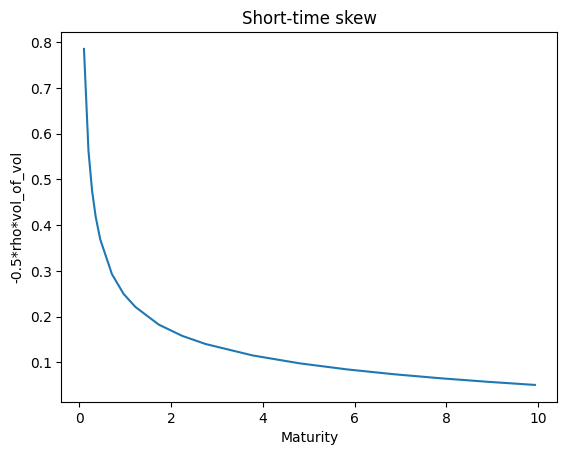

In [20]:
import matplotlib.pyplot as plt

# let's say we have two lists
list1 = rho_times_volofvol
list2 = maturity_list  # This can be your product_list

plt.plot(list2, list1)  # Plot with list2 as x-axis and list1 as y-axis

plt.xlabel('Maturity')  # Label for x-axis
plt.ylabel('-0.5*rho*vol_of_vol')  # Label for y-axis

plt.title('Short-time skew')  # Title of the plot

plt.show()  # Display the plot

In [ ]:
def optimize_params_gd(df, fwd_list, maturity_list, params_init):
    optimized_params = [] # to store optimized parameters for each pair
    K = df.iloc[:, 0] # get strike prices from the first column
    learning_rate = 0.01 # Initialize the learning rate
    num_iterations = 100000 # Number of iterations for the gradient descent

    for i, (F, T) in tqdm(enumerate(zip(fwd_list, maturity_list), start=1)): # start from 1 to skip the first column (strike prices)
        market_vols = df.iloc[:, i] # get market volatilities from the i-th column
        params = np.copy(params_init)

        for j in range(num_iterations):
            grad = gradient(params, F, K, T, market_vols)
            params -= learning_rate * grad

        optimized_params.append(params) # append the optimized parameters

    return optimized_params

# call the function
optimized_params_list = optimize_params_gd(dataframe_all, fwd_list, maturity_list, params_init)

print("Optimized parameters [alpha, rho, nu] for each (F, T) pair: ", optimized_params_list)

18it [2:32:28, 508.25s/it]

Optimized parameters [alpha, rho, nu] for each (F, T) pair:  [array([ 0.15760111, -0.65812329,  2.27215082]), array([ 0.12725419, -0.65405296,  1.72035298]), array([ 0.13167187, -0.65088565,  1.46064844]), array([ 0.13496388, -0.6473404 ,  1.29249334]), array([ 0.13694117, -0.64411357,  1.14658957]), array([ 0.14173256, -0.63627172,  0.92086268]), array([ 0.14449938, -0.63083663,  0.79124218]), array([ 0.1495012 , -0.62874733,  0.70380609]), array([ 0.15610522, -0.61607167,  0.59266038]), array([ 0.1635214 , -0.60566761,  0.52158466]), array([ 0.16680306, -0.59455199,  0.47138294]), array([ 0.17728171, -0.57101357,  0.40364428]), array([ 0.18727244, -0.54590703,  0.35901279]), array([ 0.19696829, -0.51881689,  0.32626958]), array([ 0.20656156, -0.49095751,  0.30173131]), array([ 0.21625982, -0.46219601,  0.28212299]), array([ 0.22639102, -0.43270849,  0.26595542]), array([ 0.23146153, -0.40225955,  0.25231838])]


In [ ]:
# ### Save results         UNCOMMENT IF RUNNING FROM SCRATCH
# import pickle
# with open('results_calibration_all.obj', 'wb') as file:
#   pickle.dump(optimized_params_list, file)

In [21]:
import pickle
with open('results_calibration_all.obj', 'rb') as file:
    results_calibration_all = pickle.load(file)

In [22]:
data_provided = pd.read_excel("results_we_have.xlsx", header = None, index_col = None)

In [23]:
list_of_arrays_provided = [data_provided[col].values for col in data_provided.columns]
list_of_arrays_provided

[array([ 0.11431366, -0.65564201,  2.40471704]),
 array([ 0.12744631, -0.65349856,  1.71968568]),
 array([ 0.132048  , -0.65178384,  1.45940303]),
 array([ 0.13559354, -0.65006914,  1.29055884]),
 array([ 0.13769952, -0.64792581,  1.14444538]),
 array([ 0.1427646 , -0.64235334,  0.9183968 ]),
 array([ 0.14546217, -0.63678117,  0.78916967]),
 array([ 0.14993737, -0.63120928,  0.70285433]),
 array([ 0.15672683, -0.62006639,  0.59150653]),
 array([ 0.16401334, -0.60892465,  0.52068042]),
 array([ 0.16726209, -0.59778408,  0.47055065]),
 array([ 0.17788544, -0.57550642,  0.40272778]),
 array([ 0.18825861, -0.55323341,  0.35786916]),
 array([ 0.19857313, -0.53053686,  0.32483948]),
 array([ 0.20897651, -0.50827323,  0.30002455]),
 array([ 0.21963852, -0.48601424,  0.28019077]),
 array([ 0.23087461, -0.46375991,  0.26386631]),
 array([ 0.23708821, -0.44151021,  0.25012429])]

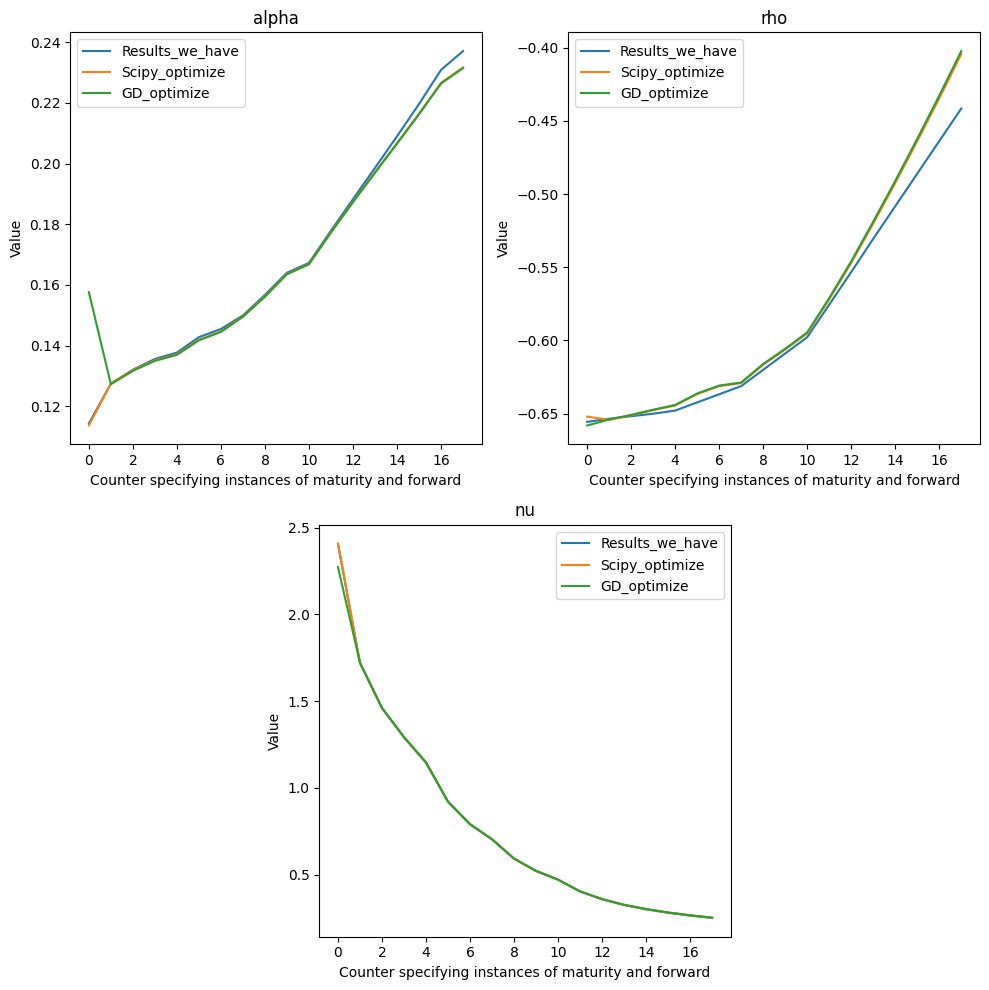

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker  # import the ticker module

array1 = np.array(list_of_arrays_provided)
array2 = np.array(optimized_params_list_scipy)
array3 = np.array(results_calibration_all)

titles = ["alpha", "rho", "nu"]

# Create a 2x4 grid of plots
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 4)

axs = [plt.subplot(gs[0, 0:2]), plt.subplot(gs[0, 2:]), plt.subplot(gs[1, 1:3])]

# Plot each element of the arrays separately
for i in range(len(titles)):
    axs[i].plot(array1[:, i], label="Results_we_have") # Plot elements from results array
    axs[i].plot(array2[:, i], label="Scipy_optimize") # Plot elements from scipy array
    axs[i].plot(array3[:, i], label="GD_optimize")  #Plot elements from GD array
    axs[i].legend() # Show a legend
    axs[i].set_title(titles[i]) # Title the plot

    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Set the x-axis to only use integer values

    # Set the labels for the y-axis and x-axis
    axs[i].set_ylabel("Value")
    axs[i].set_xlabel("Counter specifying instances of maturity and forward")

# Show the plots
plt.tight_layout()
plt.show()

In [37]:
dataframe_all_new = pd.read_excel("Market_vol_all_new.xlsx")
dataframe_all_new.head()
dataframe_all_new.columns[0]

'Strike'

In [38]:
dataframe_all_new.set_index(dataframe_all_new.columns[0], inplace=True)
dataframe_all_new.head()

,0.1011236,0.1994382,0.27808989,0.35674157,0.45505618,0.71067416,0.96629213,1.22191011,1.73314607,2.24438202,2.75561798,3.77808989,4.8005618,5.84269663,6.86516854,7.88764045,8.91011236,9.93258427
Strike,,,,,,,,,,,,,,,,,,
100,1.903188,1.501759,1.336821,1.226647,1.126206,0.967003,0.870862,0.805238,0.722324,0.667725,0.626861,0.573689,0.539000,0.514056,0.496268,0.483033,0.473398,0.461672
200,1.605828,1.273175,1.136286,1.044790,0.961193,0.828644,0.748439,0.693296,0.624570,0.579028,0.545100,0.501170,0.472776,0.452612,0.438516,0.428326,0.421286,0.411910
300,1.426396,1.135000,1.014975,0.934717,0.861269,0.744791,0.674209,0.625379,0.565241,0.525178,0.495467,0.457163,0.432622,0.415404,0.403600,0.395320,0.389926,0.382041
400,1.296034,1.034478,0.926673,0.854565,0.788483,0.683676,0.620092,0.575844,0.521965,0.485893,0.459267,0.425085,0.403381,0.388345,0.378252,0.371410,0.367268,0.360515
500,1.192850,0.954824,0.856672,0.791003,0.730749,0.635179,0.577139,0.536515,0.487607,0.454703,0.430536,0.399645,0.380217,0.366942,0.358239,0.352574,0.349466,0.343647


In [39]:
df_scipy = pd.DataFrame(optimized_params_list_scipy, columns = ["alpha", "rho", "nu"])
df_scipy

,alpha,rho,nu
0,0.113652,-0.652039,2.407565
1,0.127533,-0.654229,1.718764
2,0.131909,-0.651141,1.459458
3,0.135182,-0.647642,1.291495
4,0.137128,-0.644440,1.145792
5,0.141891,-0.636623,0.920302
6,0.144651,-0.631244,0.790749
7,0.149630,-0.629160,0.703408
8,0.156227,-0.616563,0.592311
9,0.163643,-0.606201,0.521269


In [40]:
df_GD = pd.DataFrame(results_calibration_all, columns = ["alpha", "rho", "nu"])

In [41]:
df_scipy["F"] = fwd_list
df_scipy["T"] = maturity_list


In [42]:
df_GD["F"] = fwd_list
df_GD["T"] = maturity_list

In [43]:
# Initialize an empty dictionary to hold the data
data_no_calibration = {}

# Get the unique values of T
T_values = df_scipy['T'].unique()

# Loop over unique values of T
for T in T_values:
    # Extract the rows of df_scipy for this value of T
    df_scipy_T = df_scipy[df_scipy['T'] == T]

    # Assume that F0, alpha, rho, and nu are the same for all rows with the same T
    F0 = df_scipy_T['F'].iloc[0]

    # Calculate the result for all K values and store in the data dictionary
    data_no_calibration[T] = [SABR2Black76(F0, K, T, 0.14546217, -0.63678117,  0.78916967) for K in dataframe_all_new.index]

# Convert the data dictionary to a DataFrame
df_output_no_calibration = pd.DataFrame(data_no_calibration, index=dataframe_all_new.index)

In [44]:
# Initialize an empty dictionary to hold the data
data = {}

# Get the unique values of T
T_values = df_scipy['T'].unique()

# Loop over unique values of T
for T in T_values:
    # Extract the rows of df_scipy for this value of T
    df_scipy_T = df_scipy[df_scipy['T'] == T]

    # Assume that F0, alpha, rho, and nu are the same for all rows with the same T
    F0 = df_scipy_T['F'].iloc[0]
    alpha = df_scipy_T['alpha'].iloc[0]
    rho = df_scipy_T['rho'].iloc[0]
    nu = df_scipy_T['nu'].iloc[0]

    # Calculate the result for all K values and store in the data dictionary
    data[T] = [SABR2Black76(F0, K, T, alpha, rho, nu) for K in dataframe_all_new.index]

# Convert the data dictionary to a DataFrame
df_output = pd.DataFrame(data, index=dataframe_all_new.index)

In [45]:
# Initialize an empty dictionary to hold the data
data_GD = {}

# Get the unique values of T
T_values = df_GD['T'].unique()

# Loop over unique values of T
for T in T_values:
    # Extract the rows of df_scipy for this value of T
    df_GD_T = df_GD[df_GD['T'] == T]

    # Assume that F0, alpha, rho, and nu are the same for all rows with the same T
    F0 = df_GD_T['F'].iloc[0]
    alpha = df_GD_T['alpha'].iloc[0]
    rho = df_GD_T['rho'].iloc[0]
    nu = df_GD_T['nu'].iloc[0]

    # Calculate the result for all K values and store in the data dictionary
    data_GD[T] = [SABR2Black76(F0, K, T, alpha, rho, nu) for K in dataframe_all_new.index]

# Convert the data dictionary to a DataFrame
df_output_GD = pd.DataFrame(data_GD, index=dataframe_all_new.index)

In [48]:
df_output_no_calibration.head()

,0.101124,0.199438,0.278090,0.356742,0.455056,0.710674,0.966292,1.221910,1.733146,2.244382,2.755618,3.778090,4.800562,5.842697,6.865169,7.887640,8.910112,9.932584
Strike,,,,,,,,,,,,,,,,,,
100,0.872967,0.871519,0.871532,0.871520,0.871699,0.871587,0.871422,0.867291,0.866990,0.862726,0.862540,0.858351,0.854490,0.851087,0.848039,0.845386,0.843143,0.841162
200,0.750907,0.749367,0.749355,0.749317,0.749471,0.749271,0.749015,0.744625,0.744144,0.739528,0.739167,0.734458,0.730090,0.726190,0.722665,0.719551,0.716864,0.714450
300,0.676918,0.675312,0.675284,0.675229,0.675368,0.675111,0.674797,0.670223,0.669626,0.664767,0.664292,0.659232,0.654520,0.650285,0.646439,0.643016,0.640032,0.637329
400,0.622989,0.621330,0.621290,0.621222,0.621351,0.621050,0.620691,0.615966,0.615279,0.610223,0.609661,0.604321,0.599335,0.594834,0.590733,0.587064,0.583845,0.580914
500,0.580197,0.578490,0.578440,0.578362,0.578482,0.578145,0.577749,0.572892,0.572130,0.566903,0.566268,0.560687,0.555467,0.550737,0.546417,0.542538,0.539119,0.535992


In [46]:
df_output.head()

,0.101124,0.199438,0.278090,0.356742,0.455056,0.710674,0.966292,1.221910,1.733146,2.244382,2.755618,3.778090,4.800562,5.842697,6.865169,7.887640,8.910112,9.932584
Strike,,,,,,,,,,,,,,,,,,
100,1.903426,1.501713,1.336847,1.226738,1.126331,0.967197,0.871021,0.805294,0.722396,0.667775,0.626897,0.573723,0.539045,0.514109,0.496324,0.483067,0.473404,0.461634
200,1.605954,1.273147,1.136298,1.044837,0.961258,0.828752,0.748526,0.693327,0.624607,0.579054,0.545116,0.501184,0.472793,0.452629,0.438530,0.428320,0.421260,0.411857
300,1.426463,1.134981,1.014980,0.934741,0.861302,0.744852,0.674258,0.625396,0.565259,0.525191,0.495473,0.457168,0.432626,0.415404,0.403597,0.395302,0.389895,0.381995
400,1.296063,1.034465,0.926674,0.854574,0.788496,0.683708,0.620117,0.575852,0.521972,0.485899,0.459267,0.425085,0.403378,0.388338,0.378243,0.371388,0.367240,0.360480
500,1.192852,0.954815,0.856669,0.791002,0.730748,0.635191,0.577148,0.536517,0.487606,0.454704,0.430532,0.399642,0.380210,0.366930,0.358227,0.352553,0.349444,0.343624


In [47]:
df_output_GD.head()

,0.101124,0.199438,0.278090,0.356742,0.455056,0.710674,0.966292,1.221910,1.733146,2.244382,2.755618,3.778090,4.800562,5.842697,6.865169,7.887640,8.910112,9.932584
Strike,,,,,,,,,,,,,,,,,,
100,1.956056,1.502018,1.337085,1.226943,1.126506,0.967314,0.871131,0.805391,0.722490,0.667860,0.626990,0.573825,0.539155,0.514231,0.496456,0.483223,0.473580,0.461826
200,1.657729,1.273354,1.136457,1.044973,0.961373,0.828824,0.748594,0.693387,0.624665,0.579105,0.545174,0.501245,0.472859,0.452702,0.438607,0.428413,0.421364,0.411969
300,1.477458,1.135130,1.015092,0.934836,0.861383,0.744899,0.674301,0.625435,0.565297,0.525222,0.495509,0.457205,0.432665,0.415447,0.403641,0.395356,0.389955,0.382058
400,1.346347,1.034573,0.926753,0.854639,0.788552,0.683736,0.620142,0.575875,0.521994,0.485915,0.459288,0.425104,0.403398,0.388359,0.378261,0.371414,0.367268,0.360508
500,1.242480,0.954891,0.856722,0.791044,0.730784,0.635204,0.577159,0.536528,0.487616,0.454708,0.430540,0.399646,0.380214,0.366934,0.358226,0.352557,0.349447,0.343625


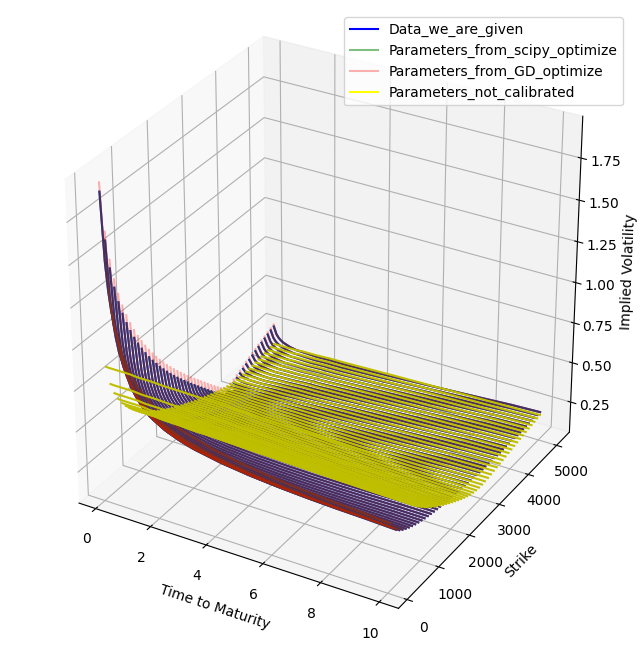

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines

# Fetch values from the first DataFrame
x1 = dataframe_all_new.index.values
y1 = dataframe_all_new.columns.values
X1, Y1 = np.meshgrid(y1, x1)
Z1 = dataframe_all_new.values

# Fetch values from the second DataFrame
x2 = df_output.index.values
y2 = df_output.columns.values
X2, Y2 = np.meshgrid(y2, x2)
Z2 = df_output.values

# Fetch values from the third DataFrame
x3 = df_output_GD.index.values
y3 = df_output_GD.columns.values
X3, Y3 = np.meshgrid(y3, x3)
Z3 = df_output_GD.values

# Fetch values from the fourth DataFrame
x4 = df_output_no_calibration.index.values
y4 = df_output_no_calibration.columns.values
X4, Y4 = np.meshgrid(y4, x4)
Z4 = df_output_no_calibration.values

# Set up the figure and axes
fig = plt.figure(figsize=(8, 10))

ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([0.5,0.5,0.5])

# Plot data from the first DataFrame
for i, xi in enumerate(x1):
    ax.plot(y1, [xi]*len(y1), Z1[i], color='b')

# Plot data from the second DataFrame
for i, xi in enumerate(x2):
    ax.plot(y2, [xi]*len(y2), Z2[i], color='g', alpha = 0.5)

# Plot data from the third DataFrame
for i, xi in enumerate(x3):
    ax.plot(y3, [xi]*len(y3), Z3[i], color='r', alpha = 0.3)

# Plot data from the fourth DataFrame
for i, xi in enumerate(x4):
    ax.plot(y4, [xi]*len(y4), Z4[i], color='y')

blue_line = mlines.Line2D([], [], color='blue', label='Data_we_are_given')
green_line = mlines.Line2D([], [], color='green', label='Parameters_from_scipy_optimize', alpha=0.5)
red_line = mlines.Line2D([], [], color='red', label='Parameters_from_GD_optimize', alpha=0.3)
yellow_line = mlines.Line2D([], [], color='yellow', label='Parameters_not_calibrated')

ax.legend(handles=[blue_line, green_line, red_line, yellow_line])

# Set labels
ax.set_xlabel('Time to Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Volatility')

plt.show()